# **Neural Machine Translation Transformer based Model**

[Reference Link we used for making up the transformer architecture for NMT model](https://arxiv.org/pdf/1706.03762)

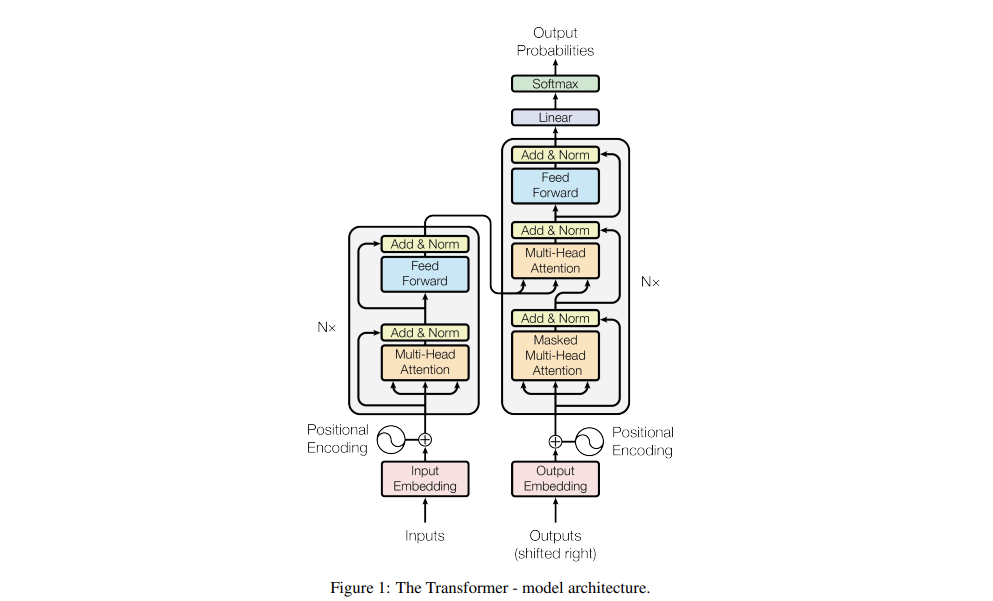

The model we are using for machine translation is a Seq-to-Seq Attention based model(Transformer). The model architecture we have defined above. And for the training purpose we used the English-Hindi dataset provided by IIT Bombay. The complete flow of the model training is - we collected the data, converted into suitable dataframe then tokenized hindi and english sentences using Indic-NLP and Spacey tokenizer respectively and generated the vocabulary for both languages. Then we used it to train our transformer model, which we tested over some example translations and also made an interactive session. We also evaluated our model on BLEU score and it is giving satisfactory results of 0.34 as the BLEU score.

In [1]:
# Mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing all the Required dependencies

In [2]:
!pip install torch==1.13.0 torchtext==0.6.0

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.data import Field
import spacy
import sys

print("Loading English spaCy model...")
spacy_eng = spacy.load("en_core_web_sm")
print("English spaCy model loaded successfully")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.5.2 requires torch>=2.0.0, but you have torch 1.13.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 1.13.0 which is incompati

#### We are using Indic-NLP library for tokenising and Preprocessing of the hindi sentences we get from the dataset

In [ ]:
!pip install indic-nlp-library
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git

import sys
from indicnlp import common

INDIC_NLP_LIB_HOME = "indic_nlp_library"
INDIC_NLP_RESOURCES = "indic_nlp_resources"

sys.path.append(f"{INDIC_NLP_LIB_HOME}/src")
common.set_resources_path(INDIC_NLP_RESOURCES)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.9 MB/s eta 0:00:00


#### Example testing of the Indic-NLP tokeniser

In [6]:
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize
from indicnlp.transliterate import unicode_transliterate
from indicnlp import common

# Testing the tokeniser
hindi_text = "नमस्ते दुनिया!"
tokens = indic_tokenize.trivial_tokenize(hindi_text)
print(tokens)

['नमस्ते', 'दुनिया', '!']


#### We are using spacey for English sentences tokenisation and defining the tokeniser functions for both

In [7]:
def tokenize_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

def tokenize_hindi(text):
    return [tok for tok in indic_tokenize.trivial_tokenize(text)]

#### Preprocessing and Building Vocabulary for both the languages

In [ ]:
normalizer_factory = IndicNormalizerFactory()
normalizer = normalizer_factory.get_normalizer("hi")

# Defining Field
english_txt = Field(tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")
hindi_txt = Field(tokenize=tokenize_hindi, init_token="<sos>", eos_token="<eos>")

# Defining Tabular Dataset
print("Loading training and validation datasets...")
data_fields = [('eng_text', english_txt), ('hindi_text', hindi_txt)]

try:
    # Try loading from Colab's /content directory
    train_dt, val_dt = TabularDataset.splits(
        path='/content',
        train='train.csv',
        validation='val.csv',
        format='csv',
        fields=data_fields
    )
    print("Datasets loaded from /content.")
except FileNotFoundError:
    try:
        # Fallback: Try loading from Google Drive
        drive_path = '/content/drive/MyDrive/NLP_Proj/'  # Adjust path as needed
        train_dt, val_dt = TabularDataset.splits(
            path=drive_path,
            train='train.csv',
            validation='val.csv',
            format='csv',
            fields=data_fields
        )
        print(f"Datasets loaded from {drive_path}.")
    except FileNotFoundError as e:
        print("Error: Could not find train.csv and/or val.csv in either /content or Google Drive.")
        raise e
print(f"Training dataset size: {len(train_dt)}")
print(f"Validation dataset size: {len(val_dt)}")

# Building word vocab
print("Building vocabulary...")
english_txt.build_vocab(train_dt, max_size=10000, min_freq=2)
hindi_txt.build_vocab(train_dt, max_size=10000, min_freq=2)
print(f"English vocabulary size: {len(english_txt.vocab)}")
print(f"Hindi vocabulary size: {len(hindi_txt.vocab)}")

Loading training and validation datasets...
Datasets loaded from /content/drive/MyDrive/NLP_Proj/.
Training dataset size: 1317075
Validation dataset size: 146343
Building vocabulary...
English vocabulary size: 10004
Hindi vocabulary size: 10004



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

#### Defining the model Hyperparameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_model = True

# Training hyperparameters
num_epochs = 10
learning_rate = 3e-4
batch_size = 256

# Model hyper-parameters
src_vocab_size = len(english_txt.vocab)
trg_vocab_size = len(hindi_txt.vocab)
embedding_size = 512
num_heads = 8
num_layers = 3
dropout = 0.10
max_len = 10000
forward_expansion = 4
src_pad_idx = english_txt.vocab.stoi["<pad>"]
trg_pad_idx = 0

#### Defining the Bucket Iterator

Note:-
We are using bucketIterator from TorchText to group sentences of similar lengths into batches and reducing the need for padding shorter sequences which helps in reducing the memory usage and improves the training process and efficiency

In [ ]:
train_iter = BucketIterator(train_dt, batch_size=batch_size, sort_key=lambda x: len(x.eng_text), shuffle=True)
val_iter = BucketIterator(val_dt, batch_size=batch_size, sort_key=lambda x: len(x.eng_text), shuffle=True)

### Defining the Self-Attention for the Transformer

<p>So the flow in the self attention block is like this firstly the input tensors(queries,keys and values are passed through the linear projections, then the projected tensors are split into multiple heads so that it can put attention to different parts of the input sequence parallely.Then we are calculating the attention score using the torch einstein which is essential for scaled dot-product attention between the queries and keys to the attention scores. then we are doing the masking to avoid the paddings, then we are applying the softmax and scaling to get the probability distribution and then using them to get the context vector from the entire sequence.</p>

In [9]:
import torch
import torch.nn as nn
import math

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        # Dividing word's embedding into 'H' different heads
        # For ex: embed_size = 512 & heads = 8
        # Then 8 heads of 64 size are created
        assert (self.embed_size % self.heads == 0)

        self.values = nn.Linear(in_features=self.embed_size, out_features=self.embed_size, bias=False)
        self.keys = nn.Linear(in_features=self.embed_size, out_features=self.embed_size, bias=False)
        self.queries = nn.Linear(in_features=self.embed_size, out_features=self.embed_size, bias=False)
        self.fc_out = nn.Linear(in_features=self.head_dim * self.heads, out_features=self.embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        score = torch.einsum("nqhd,nkhd -> nhqk", queries, keys)

        if mask is not None:
            score = score.masked_fill(mask == 0, float('-1e20'))
        attention_score = torch.softmax(score / math.sqrt(self.head_dim), dim=-1)
        out = torch.einsum("nhql,nlhd->nqhd", attention_score, values).reshape(N, query_len, self.heads*self.head_dim)

        out = self.fc_out(out)
        return out

### Tranformer Block used to build the Transformer

<p>
In this we are implementing the transformer encoder block which consists of multi-head self-attention followed by a position-wise feed-forward network, with residual connections and layer normalization. The flow is like this it receives the key, value, query tensors and mask.
It then passed to the self attention block, then output from the attention layer is combined with the original query through a residual connection (attention + query). Then we are doing layer normalization (norm1) is applied to stabilize the learning process by normalizing the activation, also doing dropout to prevent overfitting. Then the normalized output is processed through a two-layer feed-forward network. The output from the feed-forward network is combined with its input (forward + x) through another residual connection, then we are applying another layer normalization (norm2) to the combined output.
</p>

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size=embed_size, heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_fwd = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask=None):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_fwd(x)
        out = self.dropout(self.norm2(forward + x))
        return out

### Positional Encoding 

Note:-
The Positional Encoding module addresses a fundamental limitation in transformer models - their inability to understand sequence order. It works by creating position-specific patterns using sine and cosine functions of varying frequencies that are added to word embeddings.

First, we create a zero tensor matching our maximum sequence length and embedding size, then generate position indices. For each position, we compute sine values for even indices and cosine values for odd indices of the embedding dimension using carefully scaled frequency terms. These positional encodings maintain consistent relative distances between positions regardless of sequence length. During the forward pass, these fixed positional encodings are added directly to the input embeddings, providing the model with explicit information about token positions, before applying dropout to prevent overfitting. This approach allows transformers to process tokens in parallel while still capturing sequential information critical for language understanding.

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, embed_size, dropout, device):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).to(device)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### Decoderblock which will be used to make the Decoder

<p>This block enables the decoder to generate output sequences one token at a time while maintaining both self-context and alignment with the encoded source information</p>

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size=embed_size,
                                                  heads=heads,
                                                  dropout=dropout,
                                                  forward_expansion=forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, trg_mask, src_mask=None):
        attention = self.attention(x, x, x, mask=trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value=value, key=key, query=query, mask=src_mask)
        return out

### Encoder for the TRansformer

<p>
In this, we firstly transforms input token indices into dense vector representations through word embedding, then adds positional information via positional encoding to preserve sequence order. The resulting embedded sequence passes through multiple identical transformer layers, each containing multi-head self-attention and feed-forward components with residual connections and normalization.
</p>

In [13]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_len):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(max_len, embed_size, dropout, device=self.device)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_size=embed_size,
                                 heads=heads,
                                 dropout=dropout,
                                 forward_expansion=forward_expansion)
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.word_embedding(x)
        out = self.position_embedding(x)

        for layer in self.layers:
            out = layer(value=out, key=out, query=out, mask=mask)
        return out

### Decoder for the Transformer

<p>Firstly, we converts target sequence token indices into dense vector embeddings and applies positional encoding. After processing through all decoder layers, a final linear projection transforms the output embeddings into logits over the target vocabulary, producing probability distributions for next-token prediction.</p>

In [14]:
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_len):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(max_len, embed_size, dropout, device=self.device)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size=embed_size,
                             heads=heads,
                             dropout=dropout,
                             forward_expansion=forward_expansion,
                             device=self.device)
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)

    def forward(self, x, enc_out, trg_mask, src_mask=None):
        x = self.word_embedding(x)
        x = self.position_embedding(x)

        for layer in self.layers:
            x = layer(x=x, value=enc_out, key=enc_out, trg_mask=trg_mask, src_mask=src_mask)

        dec_out = self.fc_out(x)
        return dec_out

### Transformer 

<p>In this, we implemented the complete transformer architecture for neural machine translation, combining encoder and decoder components which we studied from the "Attention is All You need". It creates an encoder for processing source sequences and a decoder for generating target sequences, both configured with the same hyperparameters (embedding size, number of layers, attention heads, etc.). It provides two masking methods: make_src_mask creates padding masks for the source sequence to prevent attention to padding tokens, while make_trg_mask generates a triangular causal mask ensuring the decoder only attends to previous positions. In the forward pass,it first creates appropriate masks for both source and target sequences, then processes the source sequence through the encoder to obtain contextualized representations. Then encoder outputs, along with the target sequence and both masks, are passed to the decoder which generates predictions for the next tokens in the target sequence. </p>

In [15]:
class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 trg_vocab_size,
                 src_pad_idx,
                 trg_pad_idx,
                 embed_size,
                 num_layers,
                 forward_expansion,
                 heads,
                 dropout,
                 device="cuda",
                 max_len=500):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size=src_vocab_size,
                               embed_size=embed_size,
                               num_layers=num_layers,
                               heads=heads,
                               device=device,
                               forward_expansion=forward_expansion,
                               dropout=dropout,
                               max_len=max_len)

        self.decoder = Decoder(trg_vocab_size=trg_vocab_size,
                               embed_size=embed_size,
                               num_layers=num_layers,
                               heads=heads,
                               device=device,
                               forward_expansion=forward_expansion,
                               dropout=dropout,
                               max_len=max_len)

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len)))
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src=src)
        trg_mask = self.make_trg_mask(trg=trg)
        enc_src = self.encoder(x=src, mask=src_mask)
        out = self.decoder(x=trg, enc_out=enc_src, trg_mask=trg_mask, src_mask=src_mask)
        return out

<p>This part is saving and loading functions for pytorch model</p>

In [16]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

<p>Here we instantiated the Transformer, optimizer and scheduler for the model training.</p>

In [17]:
model = Transformer(src_vocab_size=src_vocab_size,
                    trg_vocab_size=trg_vocab_size,
                    src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    embed_size=embedding_size,
                    num_layers=num_layers,
                    forward_expansion=forward_expansion,
                    heads=num_heads,
                    dropout=dropout,
                    device=device,
                    max_len=max_len).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

pad_idx = hindi_txt.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
loss_tracker = []

<p>This is the training loop code for the NMT. Here we have trained the model over 10 epoch which took around 7.5 hrs. We also also done the gradient clipping to prevent the exploding gradient problem.</p>

### Beam Search

<p> Here we implemented the beam search.It implements the beam search decoding algorithm for a sequence-to-sequence model (like a Transformer used for translation). It takes a source sentence, tokenizes and encodes it, then iteratively generates potential target sequences by expanding the k most probable partial sequences (beams) at each step using the model's decoder. </p>

In [19]:
import copy

def beam_search(sentence, model, src_field, src_tokenizer, trg_field, trg_vcb_sz, k=5, max_ts=50, device="cpu"):
    model.eval()

    sentence_tok = src_tokenizer(sentence)
    sentence_tok.insert(0, src_field.init_token)
    sentence_tok.append(src_field.eos_token)

    src_tok = torch.tensor([src_field.vocab.stoi[token] for token in sentence_tok], dtype=torch.long).unsqueeze(0).to(device)
    trg_tok = torch.tensor([[trg_field.vocab.stoi[trg_field.init_token]]], dtype=torch.long).to(device)

    eos_idx = trg_field.vocab.stoi[trg_field.eos_token]
    src_mask = model.make_src_mask(src_tok)

    with torch.no_grad():
        enc_src = model.encoder(src_tok, src_mask)

    completed_sequences = {}
    curr_beams = [(trg_tok, 0)]

    for step in range(max_ts):
        next_beams = []

        if len(curr_beams) == 0:
            break

        for seq, seq_log_prob in curr_beams:
            if seq[0, -1].item() == eos_idx and step > 0:
                completed_sequences[seq_log_prob] = seq
                continue

            trg_mask = model.make_trg_mask(seq)
            with torch.no_grad():
                output = model.decoder(seq, enc_src, trg_mask, src_mask)
                output = output[:, -1, :]
                log_probs = torch.log_softmax(output, dim=-1)
                top_log_probs, top_indices = torch.topk(log_probs, k=k, dim=-1)
                for i in range(k):
                    next_token = top_indices[0, i].unsqueeze(0).unsqueeze(0)
                    next_log_prob = top_log_probs[0, i].item()

                    new_seq = torch.cat([seq, next_token], dim=1)
                    new_seq_log_prob = seq_log_prob + next_log_prob

                    if next_token.item() == eos_idx:
                        completed_sequences[new_seq_log_prob] = new_seq
                    else:
                        next_beams.append((new_seq, new_seq_log_prob))

        next_beams.sort(key=lambda x: x[1], reverse=True)
        curr_beams = next_beams[:k]

        if len(completed_sequences) >= k:
            break

    if completed_sequences:
        best_seq_log_prob = max(completed_sequences.keys())
        best_seq = completed_sequences[best_seq_log_prob]
    else:
        if curr_beams:
            best_seq = curr_beams[0][0]
        else:
            return "Translation failed"

    tokens = [trg_field.vocab.itos[idx] for idx in best_seq.squeeze().tolist()[1:]]
    if tokens and tokens[-1] == trg_field.eos_token:
        tokens = tokens[:-1]

    return " ".join(tokens)

### Greedy Search

<p>It generates a target sequence from a source sequence src using a pre-trained sequence-to-sequence model. It first encodes the entire source sequence. Then, starting with an initial target token (like <sos>), it iteratively predicts the next token by feeding the current target sequence and the encoded source into the decoder and selecting the token with the highest probability at each step.</p>

In [20]:
def greedy_decode(model, src, max_len, src_mask, device, trg_field):
    model.eval()

    with torch.no_grad():
        enc_src = model.encoder(src, src_mask)

    trg_idx = [trg_field.vocab.stoi[trg_field.init_token]]

    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_idx).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:, -1].item()
        trg_idx.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_idx]
    if trg_tokens[-1] == trg_field.eos_token:
        trg_tokens = trg_tokens[:-1]
    return trg_tokens[1:]

<p> Translate function take the input sentence perform the beam search and greedy search and give the translated sentence</p>

In [21]:
def translate(model, sentence, english_txt, hindi_txt, tokenize_eng, device, beam_size=5, max_len=50):
    model.eval()
    tokens = tokenize_eng(sentence)
    tokens.insert(0, english_txt.init_token)
    tokens.append(english_txt.eos_token)
    src_indices = [english_txt.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    greedy_tokens = greedy_decode(model, src_tensor, max_len, src_mask, device, hindi_txt)

    beam_result = beam_search(
        sentence=sentence,
        model=model,
        src_field=english_txt,
        src_tokenizer=tokenize_eng,
        trg_field=hindi_txt,
        trg_vcb_sz=len(hindi_txt.vocab),
        k=beam_size,
        max_ts=max_len,
        device=device
    )

    return {
        'greedy': ' '.join(greedy_tokens),
        'beam': beam_result
    }

[Our Trained Model gdrive link](https://drive.google.com/file/d/1zrpxw-1YFI2aOWqAaQuR6GXlcBiESzMR/view?usp=sharing)

### BLEU Score Function

<p>Here we are defined the bleu score calculator function. It iterates through batches of source (English) and target (Hindi) text preprocess it and generate the translation using our mode then both the predicted and reference Hindi token sequences are converted back to words and truncated at the end-of-sentence marker before being collected. Finally, it utilizes nltk's corpus_bleu function with smoothing to compute and return the overall BLEU score comparing all generated predictions against their corresponding reference translations.</p>

In [22]:
def evaluate_bleu(model, data_iterator, english_txt, hindi_txt, tokenize_eng, device, beam_size=5):
    try:
        from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    except ImportError:
        print("Please install nltk: pip install nltk")
        return

    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in tqdm(data_iterator):
            src = batch.eng_text.permute(-1, -2).to(device)
            trg = batch.hindi_text.permute(-1, -2).to(device)

            src_max_len = src.shape[0]
            trg_max_len = trg.shape[0]

            if trg_max_len > src_max_len:
                trg = trg[:src_max_len, :]
            elif src_max_len > trg_max_len:
                src = src[:trg_max_len, :]

            output = model(src, trg[:, :-1])
            output = output.argmax(2)

            for i in range(output.shape[0]):
                trg_tokens = [hindi_txt.vocab.itos[token] for token in trg[i, 1:]]
                pred_tokens = [hindi_txt.vocab.itos[token] for token in output[i, :]]

                try:
                    trg_eos_idx = trg_tokens.index(hindi_txt.eos_token)
                    trg_tokens = trg_tokens[:trg_eos_idx]
                except ValueError:
                    pass

                try:
                    pred_eos_idx = pred_tokens.index(hindi_txt.eos_token)
                    pred_tokens = pred_tokens[:pred_eos_idx]
                except ValueError:
                    pass

                predictions.append(pred_tokens)
                references.append([trg_tokens])

    smooth = SmoothingFunction()
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smooth.method1)

    return bleu_score

<p>Testing Our Trained model with some test translations.</p>

In [ ]:
def test_translations(model, test_sentences, english_txt, hindi_txt, tokenize_eng, device, beam_size=5):
    print("\nTesting NMT Model\n")

    for idx, sentence in enumerate(test_sentences):
        print(f"\nExample {idx+1}: \"{sentence}\"")

        results = translate(
            model=model,
            sentence=sentence,
            english_txt=english_txt,
            hindi_txt=hindi_txt,
            tokenize_eng=tokenize_eng,
            device=device,
            beam_size=beam_size
        )

        print(f"Greedy: {results['greedy']}")
        print(f"Beam Search (k={beam_size}): {results['beam']}")
        print("-" * 50)

<p>We also defined an interactive session to take user input in English and give the translation output from our model.</p>

In [24]:
def interactive_translation(model, english_txt, hindi_txt, tokenize_eng, device, beam_size=5):
    print("\n===== Interactive Translation Mode =====")
    print("Type 'q' to quit")

    while True:
        sentence = input("\nEnter English sentence: ")

        if sentence.lower() == 'q':
            break

        results = translate(
            model=model,
            sentence=sentence,
            english_txt=english_txt,
            hindi_txt=hindi_txt,
            tokenize_eng=tokenize_eng,
            device=device,
            beam_size=beam_size
        )

        print(f"Greedy: {results['greedy']}")
        print(f"Beam Search (k={beam_size}): {results['beam']}")

<p>Here we loaded the model weights which we got after training then using it for testing and generating the inference and evaluation metrics</p>

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

try:
    checkpoint = torch.load('my_checkpoint.pth (9).tar', map_location=device)
    print("Model checkpoint loaded successfully!")
except Exception as e:
    print(f"Model not uploaded to google colab files. Trying to get it from google drive {e}")
    # sys.exit(1)
try:
    # Mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint = torch.load('/content/drive/MyDrive/NLP_Proj/my_checkpoint.pth (9).tar', map_location=device)
    print("From google drive: Model checkpoint loaded successfully!")
except Exception as e:
    print(f"From google drive: Model not uploaded to google drive. {e}")

model = Transformer(
    src_vocab_size=src_vocab_size,
    trg_vocab_size=trg_vocab_size,
    src_pad_idx=src_pad_idx,
    trg_pad_idx=trg_pad_idx,
    embed_size=embedding_size,
    num_layers=num_layers,
    forward_expansion=forward_expansion,
    heads=num_heads,
    dropout=dropout,
    device=device,
    max_len=max_len
).to(device)
model.load_state_dict(checkpoint['state_dict'])
print("Model weights loaded successfully!")

model.eval()

test_sentences = [
    "I love to eat delicious food.",
    "The weather is very nice today.",
    "What is your name?",
    "India is a beautiful country with rich cultural heritage.",
    "I want to learn Hindi language.",
    "The students are studying in the library.",
    "Please come to my house for dinner tonight.",
    "This translation model works well."
]

test_translations(
    model=model,
    test_sentences=test_sentences,
    english_txt=english_txt,
    hindi_txt=hindi_txt,
    tokenize_eng=tokenize_eng,
    device=device,
    beam_size=5
)

interactive_translation(
    model=model,
    english_txt=english_txt,
    hindi_txt=hindi_txt,
    tokenize_eng=tokenize_eng,
    device=device,
    beam_size=5
)

Using device: cuda
Model not uploaded to google colab files. Trying to get it from google drive [Errno 2] No such file or directory: 'my_checkpoint.pth (9).tar'
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
From google drive: Model checkpoint loaded successfully!
Model weights loaded successfully!

===== Testing NMT Model =====


Example 1: "I love to eat delicious food."
Greedy: मुझे स्वादिष्ट खाना खाने से प्यार है ।
Beam Search (k=5): मैं स्वादिष्ट खाना खाता हूँ ।
--------------------------------------------------

Example 2: "The weather is very nice today."
Greedy: मौसम आज बहुत अच्छा है ।
Beam Search (k=5): मौसम आज बहुत अच्छा है ।
--------------------------------------------------

Example 3: "What is your name?"
Greedy: आपका नाम क्या है ?
Beam Search (k=5): आपका नाम क्या है ?
--------------------------------------------------

Example 4: "India is a beautiful country with rich cultural heritage."
Gr

### JSON Output Loading

This is to be run after running the phase 1 of audio translation pipeline. 

- **Path:** Reads from `speech_output.json` stored in Google Drive. Speech output is output of the TTS model.
- **Fields Extracted:**
  - `raw_transcript`: Original transcribed text.
  - `punctuated_transcript`: Text with restored punctuation.
  - `sentences`: List of individual punctuated sentences.


In [27]:
import json

# Load the JSON output from speech module
json_path = "/content/drive/MyDrive/NLP_Proj/speech_output.json"

with open(json_path, "r") as f:
    speech_data = json.load(f)

# Extract fields
speech_to_text = speech_data["raw_transcript"]
punctuated_speech_to_text = speech_data["punctuated_transcript"]
punctuated_sentences_list = speech_data["sentences"]

print("✅ Loaded speech + punctuation data successfully!")
print("First sentence:", punctuated_sentences_list[0])


✅ Loaded speech + punctuation data successfully!
First sentence: My name is Gora I Haven't met Benoit after that day, but I know why he had come.


### Transformer-Based Translation

Translates each punctuated sentence to Hindi using the above trained Transformer model.

- **Input:** Punctuated English sentences (`punctuated_sentences_list`).
- **Translation Method:** Uses a greedy decoding approach (`beam_size=1`) for faster inference.
- **Function Call:** Invokes a custom `translate` function with the Transformer model and tokenizers.
- **Output:** Hindi translations are stored in `translated_pun_sentences_list`.
- **Debug Logging:** Prints each source sentence and its Hindi translation for verification.


In [30]:
# Step 4: Translate each sentence using YOUR custom transformer model
# This replaces the mBART translation part
print("\nTranslating sentences using custom Transformer model...")
translated_pun_sentences_list = []

for sentence in punctuated_sentences_list:
    # Use your translate function to translate the sentence
    # We'll use greedy search for better speed, but potentially lower quality compared to beam search
    translation_result = translate(
        model=model,
        sentence=sentence,
        english_txt=english_txt,
        hindi_txt=hindi_txt,
        tokenize_eng=tokenize_eng,
        device=device,
        beam_size=1  # Set beam size to 1 for greedy search
    )

    # Get the greedy search translation (best token at each decoding step)
    hindi_translation = translation_result['greedy']

    # Add the translated sentence to the list
    translated_pun_sentences_list.append(hindi_translation)

    # Print for debugging
    print(f"English: {sentence}")
    print(f"Hindi: {hindi_translation}")
    print("-" * 50)



Translating sentences using custom Transformer model...
English: My name is Gora I Haven't met Benoit after that day, but I know why he had come.
Hindi: गोरा मेरा नाम है , मैं उस दिन के बाद <unk> से मिला हूं , लेकिन मैं जानता हूं कि वह क्यों आया था ।
--------------------------------------------------
English: We were in the village traveling by the Night Train.
Hindi: हम गांव में <unk> ट्रेन से <unk> थे ।
--------------------------------------------------
English: The Army had organised a sadhana tooth for the students at the station.
Hindi: सेना ने स्टेशन पर विद्यार्थियों के लिए एक <unk> दांत का आयोजन किया था ।
--------------------------------------------------
English: We saw the message on the notice board.
Hindi: हमने नोटिस बोर्ड पर संदेश देखा ।
--------------------------------------------------
English: It said tasks are both online and on ground discussions enable participants to share ideas.
Hindi: यह कहा गया कि कार्य ऑनलाइन और जमीनी चर्चा पर प्रतिभागियों को विचारों को साझा करन

### Saving Translated Sentences

- **Output Path:** Saves the translated Hindi sentences to a JSON file.
- **Formatting:** Ensures the JSON is pretty-printed with indentation.


In [31]:
import json

output_path = '/content/drive/MyDrive/NLP_Proj/translated_pun_sentences.json'

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(translated_pun_sentences_list, f, ensure_ascii=False, indent=2)

print(f"Saved to: {output_path}")


Saved to: /content/drive/MyDrive/NLP_Proj/translated_pun_sentences.json
